In [2]:
import pickle
from reservoirpy.nodes import Reservoir, Ridge

# Load Data

In [3]:
# Function to load and inspect a pickle file
def load_and_inspect_pickle(file_path):
    try:
        # Open the pickle file in binary read mode
        with open(file_path, 'rb') as file:
            data = pickle.load(file)
        
        # Print the type and content of the loaded data
        print("Type of the loaded data:", type(data))
        # print("Contents of the loaded data:", data)
        
        return data
    except Exception as e:
        print("An error occurred:", e)


In [4]:
# Replace 'your_pickle_file.pkl' with the path to your pickle file
file_path = '/global/homes/j/joeschm/data/ST_research/NSTXU_discharges/ELM_data/dalpha_db.pkl'
data = load_and_inspect_pickle(file_path)

Type of the loaded data: <class 'list'>


In [5]:
for item in data:
    # Use lower dalpha time as the reference mask
    time_lower = item['time lower dalpha']
    data_lower = item['data lower dalpha']
    mask_lower = time_lower < 1.35

    # Apply the same mask to lower dalpha data and time
    item['time lower dalpha'] = time_lower[mask_lower]
    item['data lower dalpha'] = data_lower[mask_lower]

    # Apply the same mask to upper dalpha data and time, but use lower dalpha time as reference
    time_upper = item['time upper dalpha']
    data_upper = item['data upper dalpha']
    item['time upper dalpha'] = time_upper[mask_lower]
    item['data upper dalpha'] = data_upper[mask_lower]


# Plot data

In [8]:
import pickle
import matplotlib.pyplot as plt
import numpy as np

# Organize the data and plot
def plot_all_data(data, time_threshold=1.5, datasets_per_plot=100):
    dataset_count = 0  # Counter for datasets processed
    figure_count = 1   # Counter for figures
    
    # Initialize a figure
    plt.figure(figsize=(10, 6))
    plt.title(f'Figure {figure_count}: Overlapping Datasets')
    plt.xlabel('Time')
    plt.ylabel('Data')
    
    for item in data:
        shot_id = item['shot']

        # Data and time for lower dalpha
        data_lower = item['data lower dalpha']
        time_lower = item['time lower dalpha']
        # Filter for time < time_threshold
        mask_lower = time_lower < time_threshold
        data_lower_filtered = data_lower[mask_lower]
        time_lower_filtered = time_lower[mask_lower]

        # Data and time for upper dalpha
        data_upper = item['data upper dalpha']
        time_upper = item['time upper dalpha']
        # Filter for time < time_threshold
        mask_upper = time_upper < time_threshold
        data_upper_filtered = data_upper[mask_upper]
        time_upper_filtered = time_upper[mask_upper]

        # Plot data
        plt.plot(time_lower_filtered, data_lower_filtered, label=f'{shot_id} - Lower dalpha')
        plt.plot(time_upper_filtered, data_upper_filtered, label=f'{shot_id} - Upper dalpha')
        
        dataset_count += 1

        # If we've reached the maximum datasets for this figure, show and reset
        if dataset_count == datasets_per_plot:
            plt.legend()
            plt.tight_layout()
            plt.show()
            
            # Start a new figure
            dataset_count = 0
            figure_count += 1
            plt.figure(figsize=(10, 6))
            plt.title(f'Figure {figure_count}: Overlapping Datasets')
            plt.xlabel('Time')
            plt.ylabel('Data')

    # Show any remaining datasets in the last figure
    if dataset_count > 0:
        # plt.legend()
        plt.tight_layout()
        plt.show()


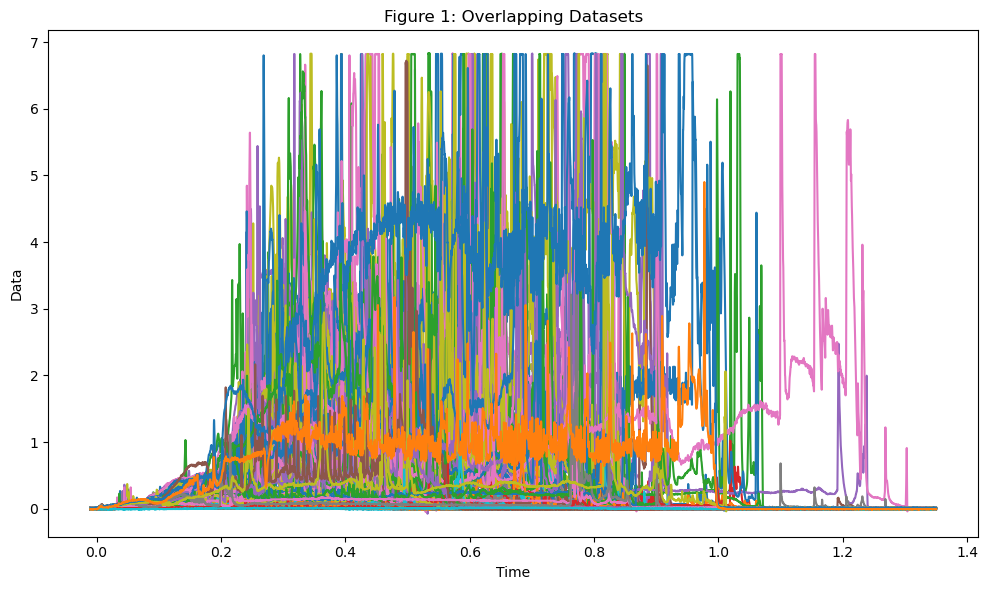

In [9]:
plot_all_data(data)

# Reservoir computer

In [24]:
import numpy as np
import matplotlib.pyplot as plt
from reservoirpy.nodes import NVAR, Ridge
from reservoirpy.observables import nrmse


# Find the shortest length across all time series
min_length = min(
    min(len(item['data lower dalpha']), len(item['data upper dalpha'])) for item in data
)

# Truncate all time series to the minimum length
for item in data:
    item['data lower dalpha'] = item['data lower dalpha'][:min_length]
    item['data upper dalpha'] = item['data upper dalpha'][:min_length]
    item['time lower dalpha'] = item['time lower dalpha'][:min_length]
    item['time upper dalpha'] = item['time upper dalpha'][:min_length]

all_series = np.stack(
    [entry['data lower dalpha'] for entry in data] +
    [entry['data upper dalpha'] for entry in data],
    axis=0
)
all_series = all_series.T
i = 15
samples = 20
all_series = all_series[:, i:i+samples]

all_series = (all_series - all_series.min()) / (all_series.max() - all_series.min())

print(all_series.shape)

(6799, 20)


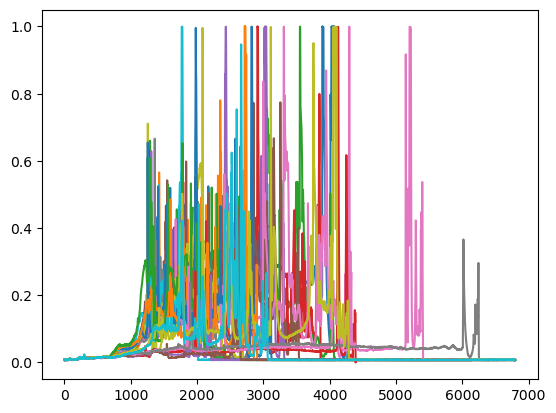

In [25]:
plt.plot(all_series)

In [26]:
def plot_train_test(X_train, y_train, X_test, y_test, sample):
    test_len = X_test.shape[0]
    fig = plt.figure(figsize=(15, 3))
    plt.plot(np.arange(0, sample), X_train[-sample:], label="Training data", color='orange')
    plt.plot(np.arange(0, sample), y_train[-sample:], label="Training ground truth", color='green')
    plt.plot(np.arange(sample, sample+test_len), X_test, label="Testing data", color='red')
    plt.plot(np.arange(sample, sample+test_len), y_test, label="Testing ground truth", color='blue')

    plt.xlim(1500,3500)
    plt.legend()
    plt.show()

(6779, 20) (6779, 20)
Time samples: 2711
X_train1: (2711, 20)
y_train1: (2711, 20)
X_test1: (4068, 20)
y_test1: (4068, 20)


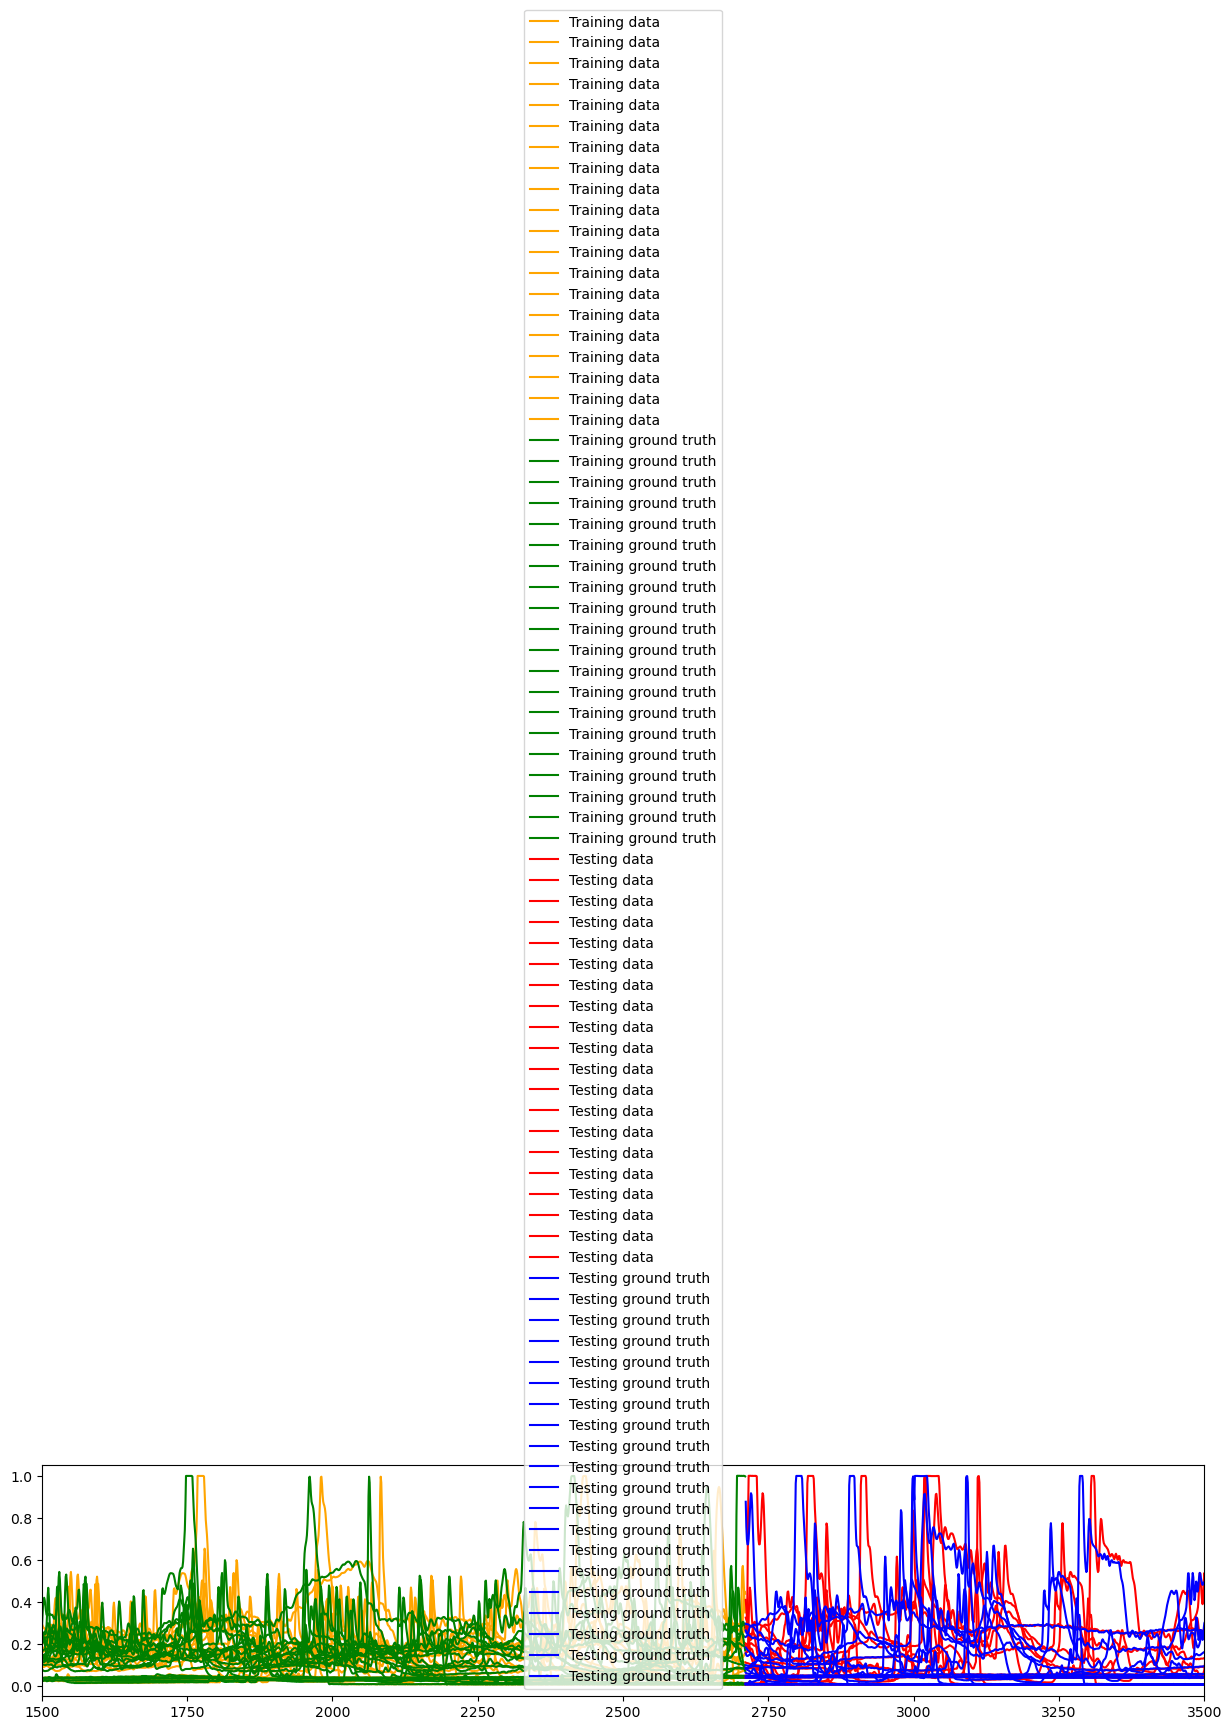

In [27]:
from reservoirpy.datasets import to_forecasting

forecast = 20
x, y = to_forecasting(all_series, forecast=forecast)
print(x.shape, y.shape)

percent_train = 0.4
time_samples = int(percent_train * x.shape[0])
print("Time samples:", time_samples)
X_train1, y_train1 = x[:time_samples], y[:time_samples]
X_test1, y_test1 = x[time_samples:], y[time_samples:]

print("X_train1:", X_train1.shape)
print("y_train1:", y_train1.shape)
print("X_test1:", X_test1.shape)
print("y_test1:", y_test1.shape)


plot_train_test(X_train1, y_train1, X_test1, y_test1, time_samples)

In [28]:
# nvar = NVAR(delay=forecast, order=2, strides=1)  # NVAR does not support .fit()
# readout = Ridge(output_dim=y_train1.shape[1], ridge=1)

# # Generate features from NVAR
# print("Transforming data with NVAR...")
# nvar_features_train = nvar.run(X_train1)  # Transform X_train1
# nvar_features_test = nvar.run(X_test1)  # Transform X_test1

# # Train the readout layer on NVAR features
# print("Training the Ridge regression readout...")
# readout = readout.fit(nvar_features_train, y_train1)

# # Test the model
# print("Evaluating the model...")
# predictions = readout.run(nvar_features_test)




nvar = NVAR(delay=forecast, order=2, strides=1)

print("Transforming data with NVAR...")
nvar_features_train = nvar.run(X_train1)  # Transform X_train1
nvar_features_test = nvar.run(X_test1)  # Transform X_test1




from sklearn.multioutput import MultiOutputRegressor
from sklearn.linear_model import SGDRegressor
from sklearn.utils import shuffle

# Define MultiOutputRegressor with SGDRegressor
sgd = SGDRegressor(penalty="l2", alpha=1e-6, max_iter=1, warm_start=True)
multi_output_sgd = MultiOutputRegressor(sgd, n_jobs=-1)  # Enable parallel processing

# Shuffle training data
X_train_shuffled, y_train_shuffled = shuffle(nvar_features_train, y_train1)

# Train in mini-batches
batch_size = 200  # Adjust based on memory
print("Training MultiOutputRegressor with SGDRegressor in mini-batches...")
for i in range(0, len(X_train_shuffled), batch_size):
    X_batch = X_train_shuffled[i:i + batch_size]
    y_batch = y_train_shuffled[i:i + batch_size]
    multi_output_sgd.partial_fit(X_batch, y_batch)

# Test the model
print("Evaluating the model...")
predictions = multi_output_sgd.predict(nvar_features_test)

Transforming data with NVAR...


Running NVAR-0:   0%|          | 0/2711 [00:00<?, ?it/s]

Running NVAR-0: 100%|██████████| 4068/4068 [00:07<00:00, 524.65it/s]


Training MultiOutputRegressor with SGDRegressor in mini-batches...
Evaluating the model...


In [29]:
# Evaluate performance
nrmse_value = nrmse(y_test1, predictions)
mse_value = np.mean((y_test1 - predictions) ** 2)
mae_value = np.mean(np.abs(y_test1 - predictions))

print(f"NRMSE: {nrmse_value:.4f}")
print(f"MSE: {mse_value:.4f}")
print(f"MAE: {mae_value:.4f}")

NRMSE: 0.0847
MSE: 0.0072
MAE: 0.0377


(4068, 20) (4068, 20)


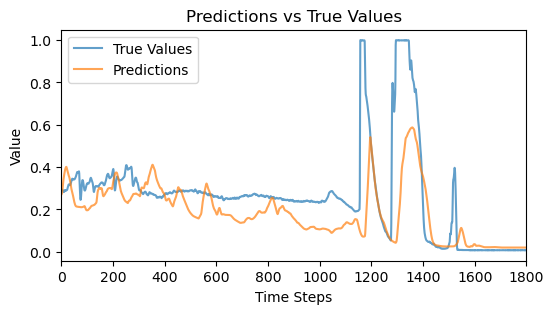

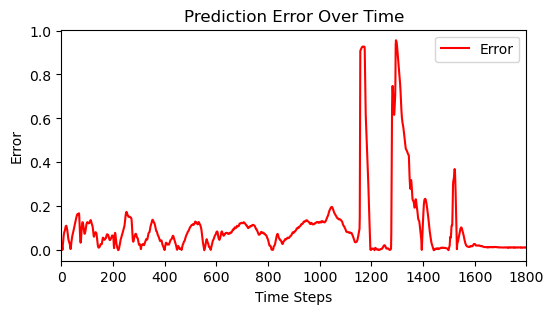

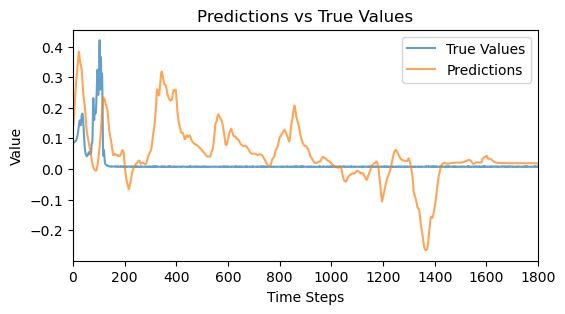

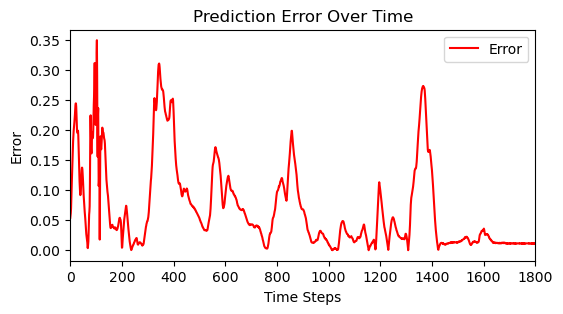

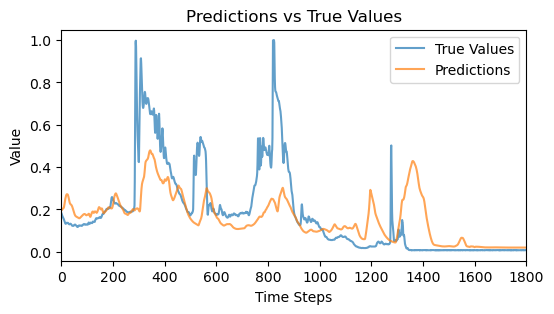

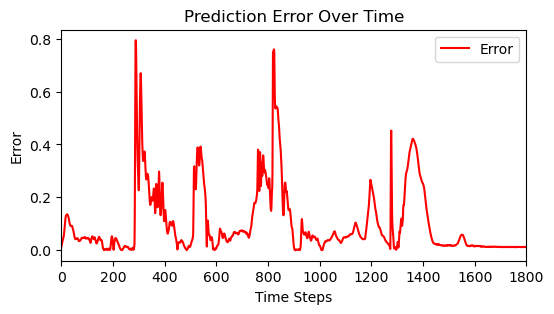

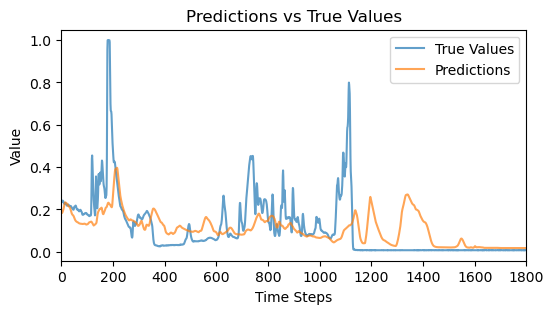

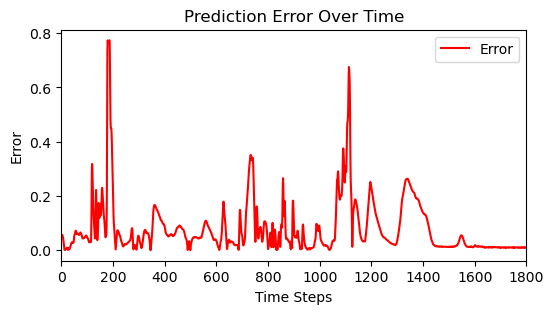

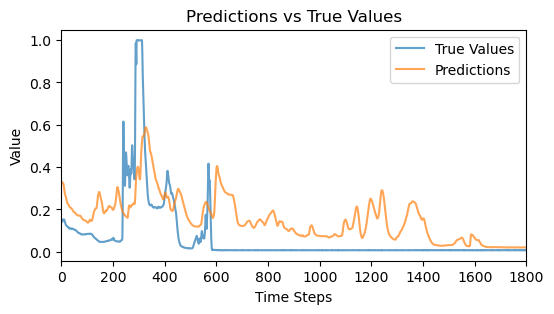

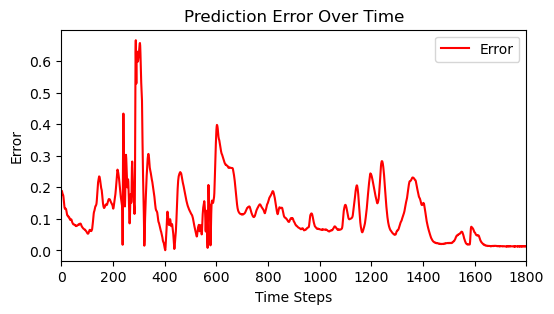

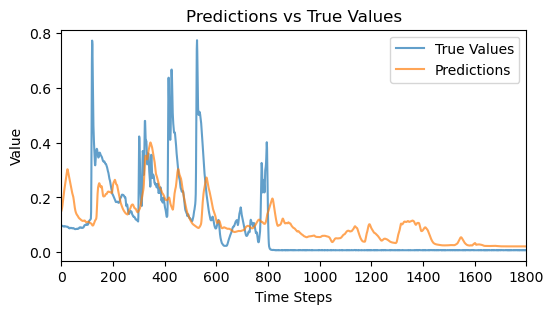

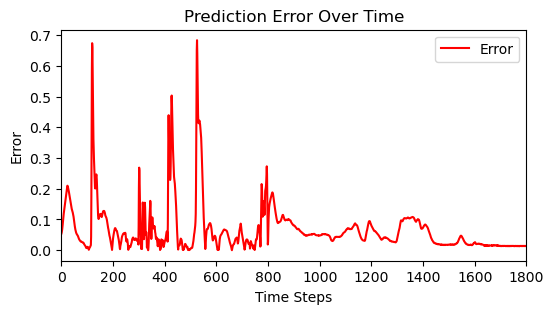

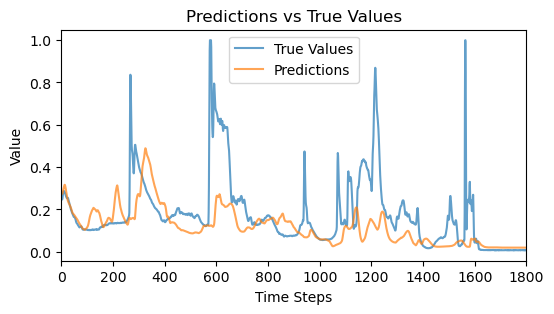

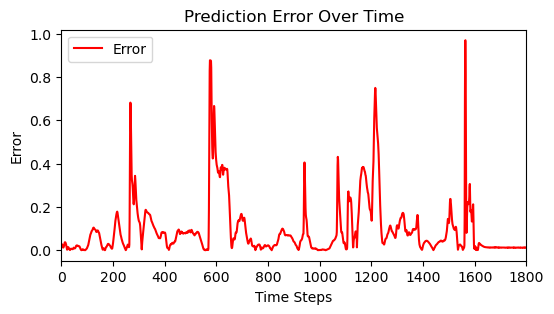

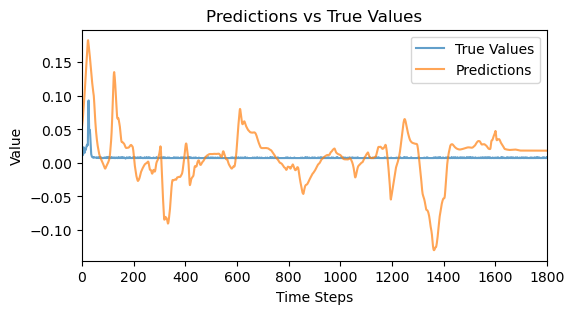

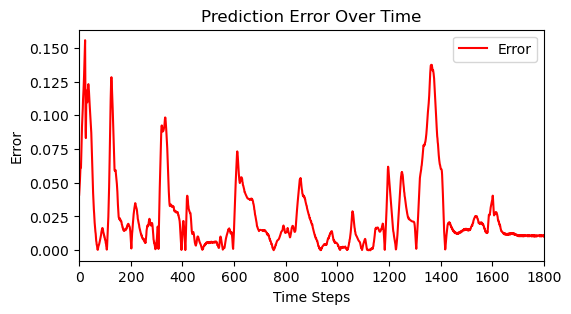

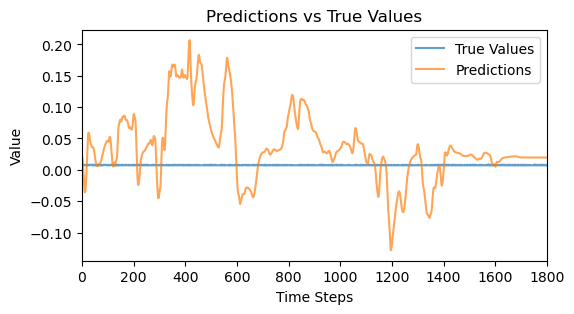

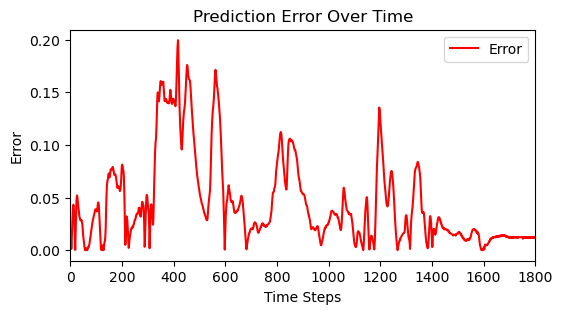

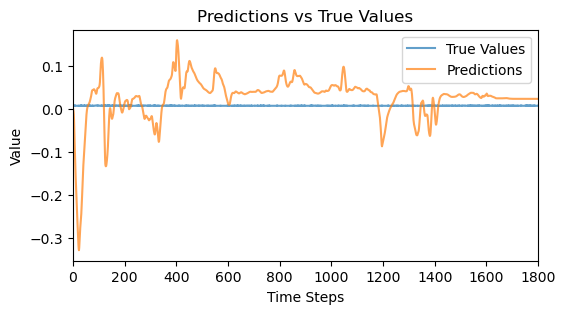

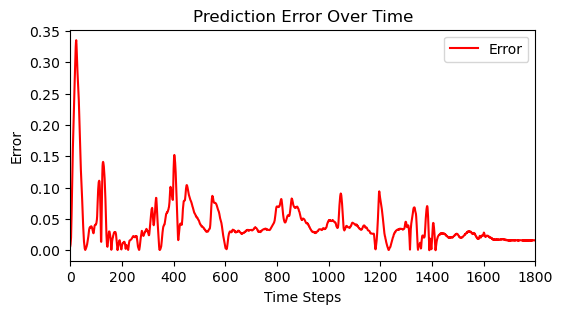

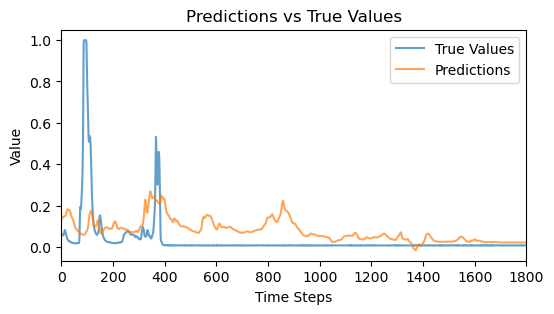

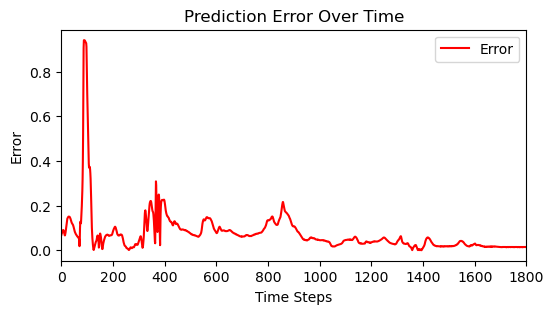

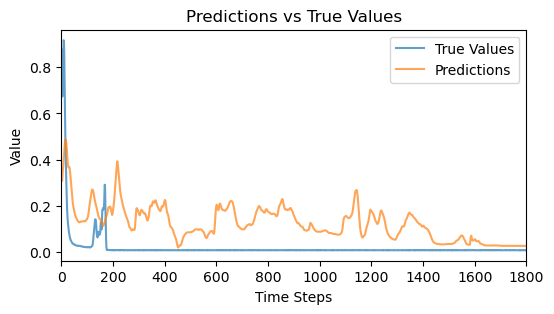

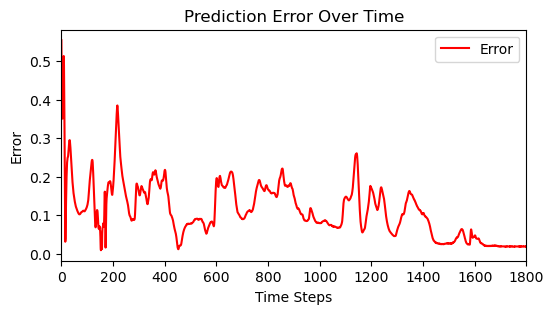

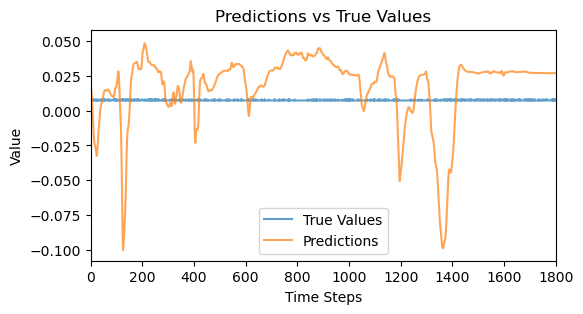

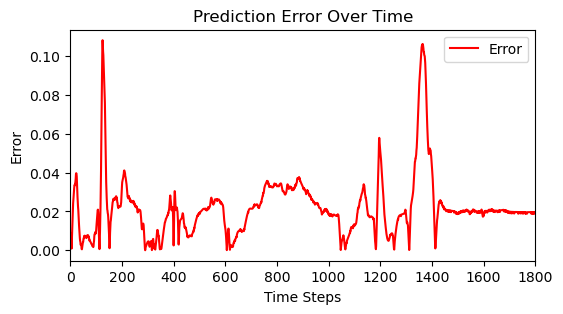

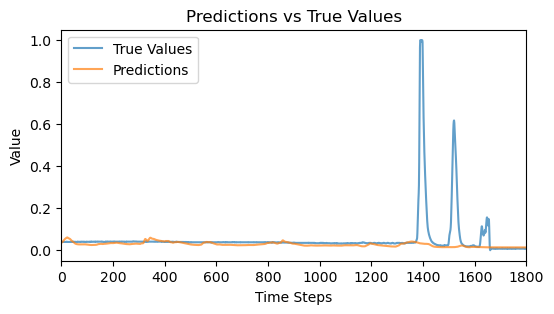

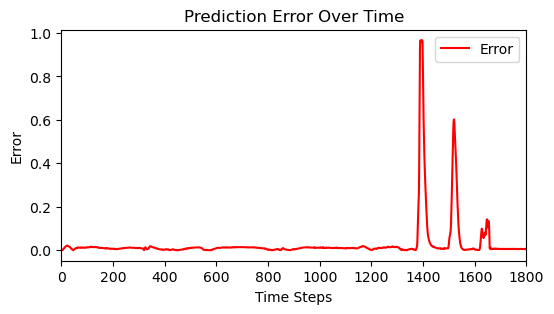

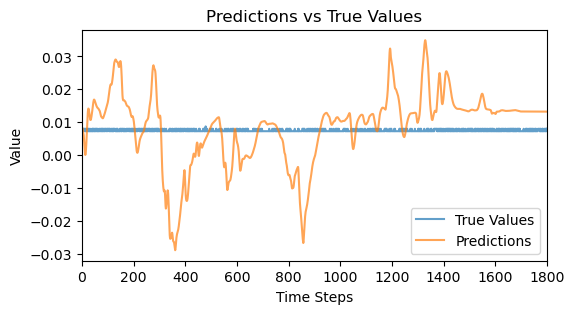

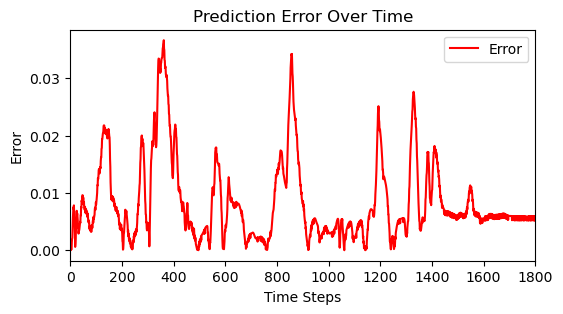

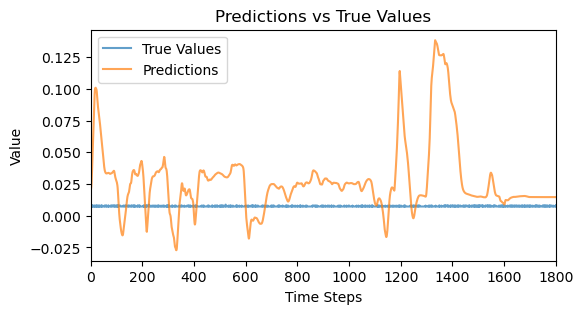

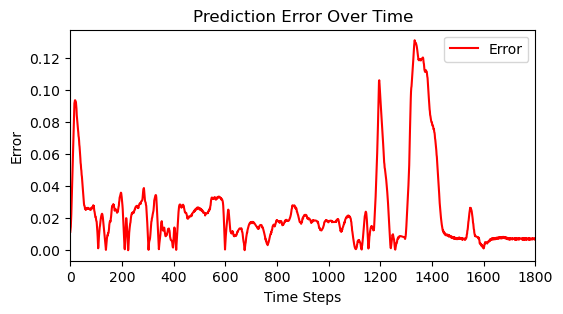

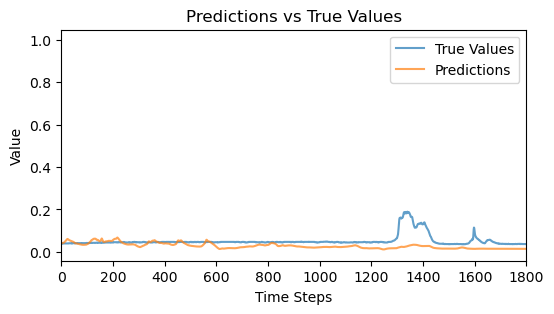

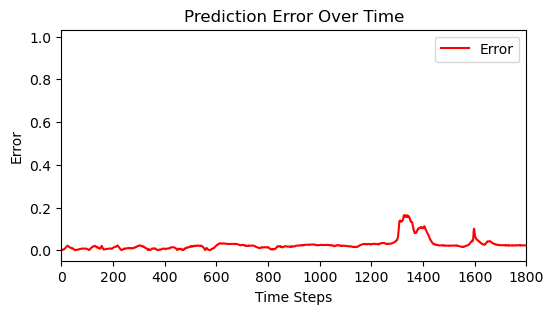

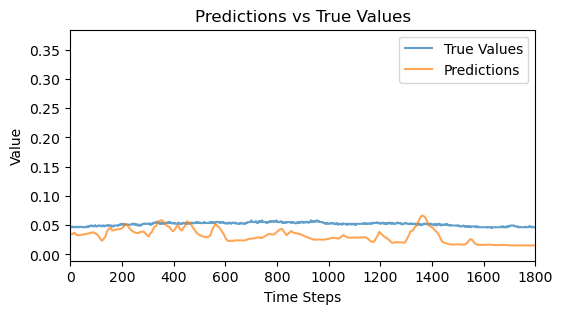

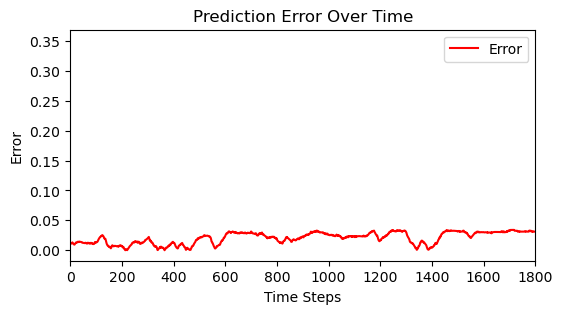

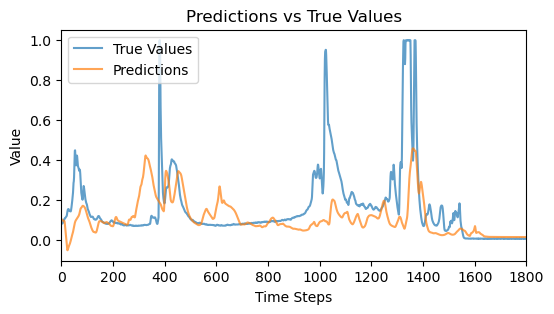

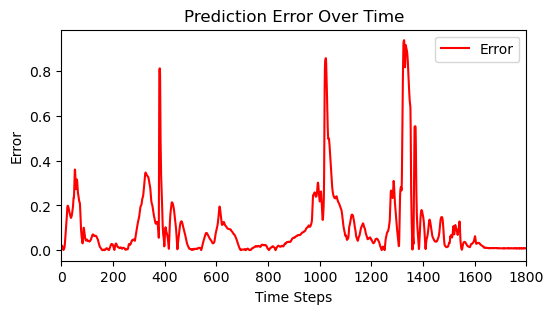

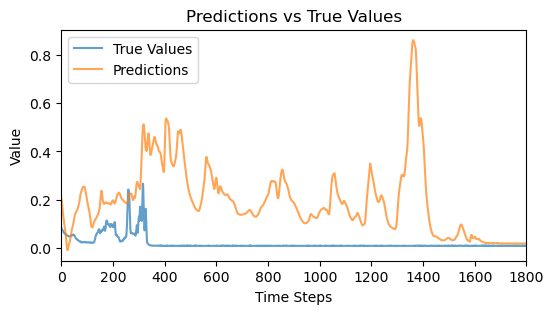

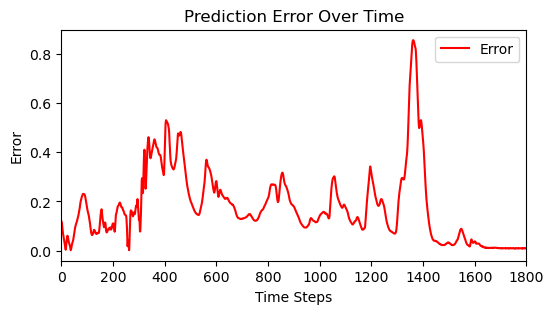

In [40]:
print(y_test1.shape, predictions.shape)

for dimension in range(y_test1.shape[1]):
    leng = 6
    plt.figure(figsize=(leng, 3))
    plt.plot(y_test1[:,dimension], label="True Values", alpha=0.7)
    plt.plot(predictions[:,dimension], label="Predictions", alpha=0.7)
    plt.legend()
    plt.title(f"Predictions vs True Values")
    plt.xlabel("Time Steps")
    plt.ylabel("Value")
    plt.xlim(0,1800)
    plt.show()

    # Plot error over time for the same dimension
    errors = np.abs(y_test1[:, dimension] - predictions[:, dimension])
    plt.figure(figsize=(leng, 3))
    plt.plot(errors, label="Error", color="red")
    plt.title(f"Prediction Error Over Time")
    plt.xlabel("Time Steps")
    plt.ylabel("Error")
    plt.xlim(0,1800)
    plt.legend()
    plt.show()

(4068, 20) (4068, 20)


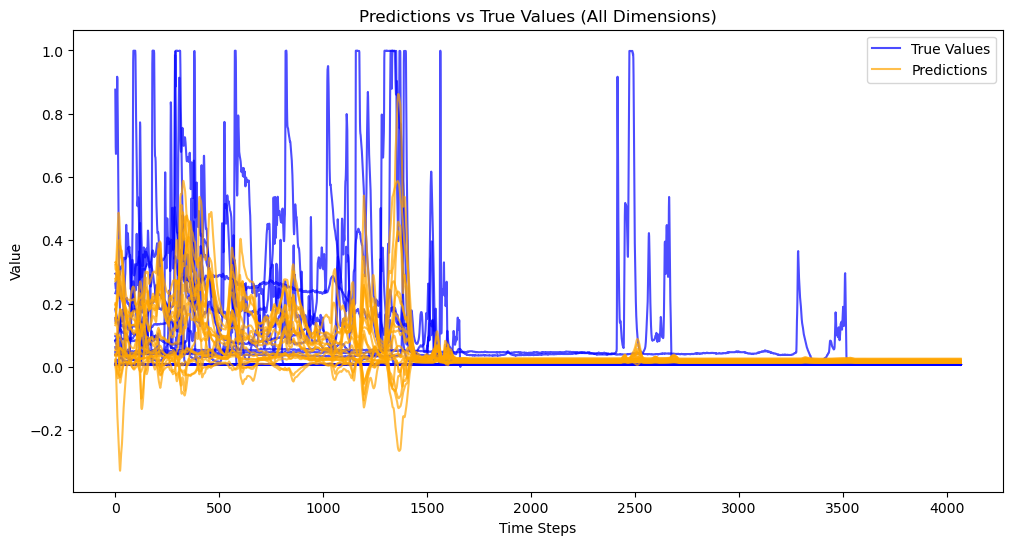

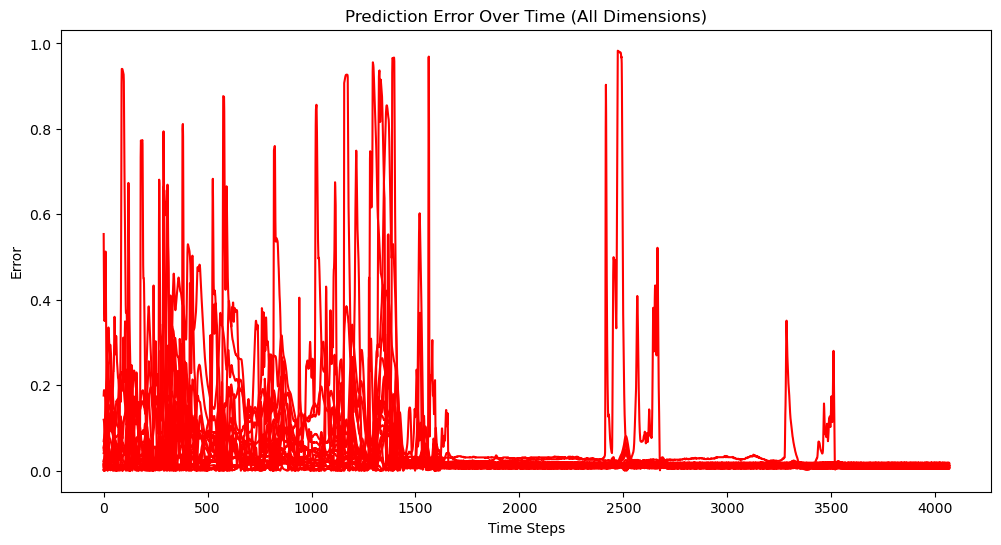

In [31]:
print(y_test1.shape, predictions.shape)

plt.figure(figsize=(12, 6))

# Plot all true values, but set the label only for the first plot
for i in range(y_test1.shape[1]):
    if i == 0:
        plt.plot(y_test1[:, i], color='blue', alpha=0.7, label='True Values')
    else:
        plt.plot(y_test1[:, i], color='blue', alpha=0.7)

# Plot all predictions, but set the label only for the first plot
for i in range(predictions.shape[1]):
    if i == 0:
        plt.plot(predictions[:, i], color='orange', alpha=0.7, label='Predictions')
    else:
        plt.plot(predictions[:, i], color='orange', alpha=0.7)

# Add legend with only two entries
plt.legend()

# Add title and labels
plt.title("Predictions vs True Values (All Dimensions)")
plt.xlabel("Time Steps")
plt.ylabel("Value")

# Display the plot
plt.show()
# Plot error over time for the same dimension
errors = np.abs(y_test1[:] - predictions[:])
plt.figure(figsize=(12, 6))
plt.plot(errors, label="Error", color="red")
plt.title(f"Prediction Error Over Time (All Dimensions)")
plt.xlabel("Time Steps")
plt.ylabel("Error")
# plt.legend()
plt.show()

Best fit dimension: 14 (Max Error: 0.0367)
Worst fit dimension: 16 (Max Error: 0.9830)


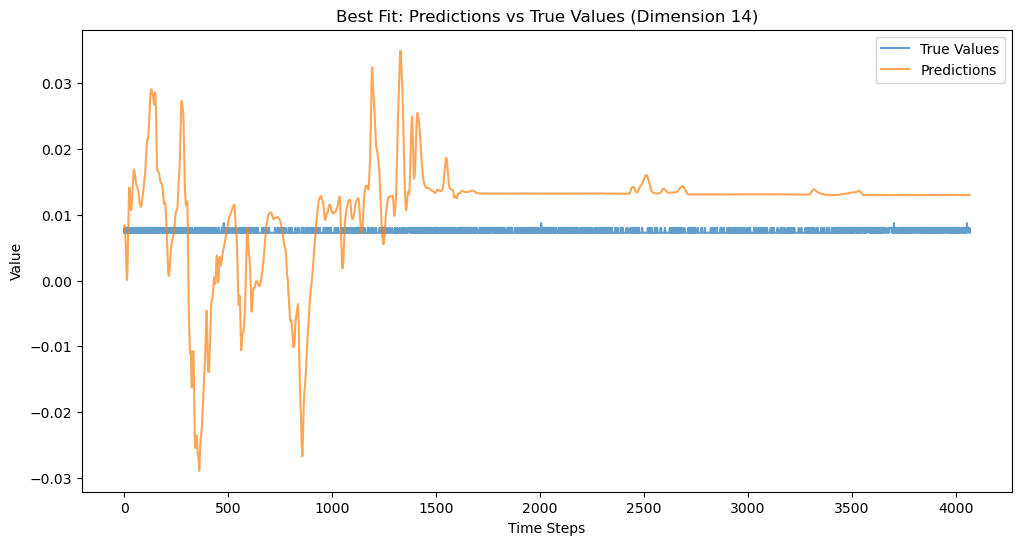

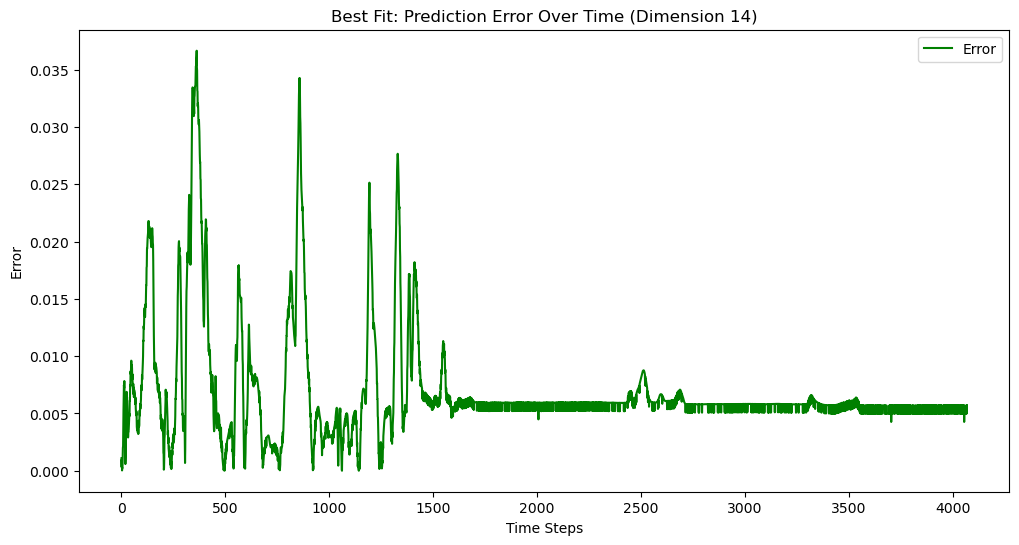

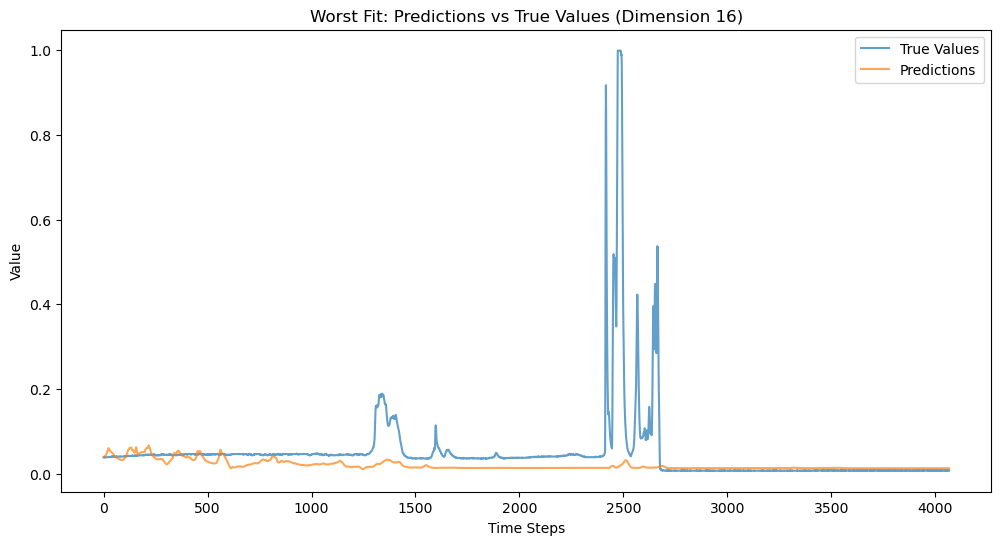

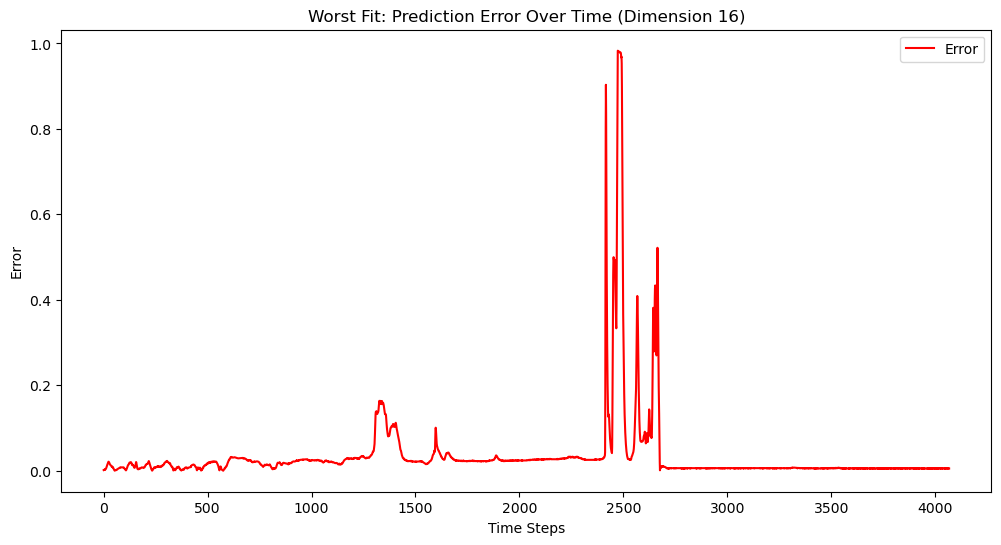

In [32]:
import numpy as np
import matplotlib.pyplot as plt

# Calculate max error for each dimension
max_error_per_dimension = np.max(np.abs(y_test1 - predictions), axis=0)

# Identify best and worst dimensions based on max error
best_fit_dimension = np.argmin(max_error_per_dimension)  # Dimension with smallest max error
worst_fit_dimension = np.argmax(max_error_per_dimension)  # Dimension with largest max error

print(f"Best fit dimension: {best_fit_dimension} (Max Error: {max_error_per_dimension[best_fit_dimension]:.4f})")
print(f"Worst fit dimension: {worst_fit_dimension} (Max Error: {max_error_per_dimension[worst_fit_dimension]:.4f})")

# Plot best-fit dimension
plt.figure(figsize=(12, 6))
plt.plot(y_test1[:, best_fit_dimension], label="True Values", alpha=0.7)
plt.plot(predictions[:, best_fit_dimension], label="Predictions", alpha=0.7)
plt.legend()
plt.title(f"Best Fit: Predictions vs True Values (Dimension {best_fit_dimension})")
plt.xlabel("Time Steps")
plt.ylabel("Value")
plt.show()

# Plot error over time for the best-fit dimension
errors_best = np.abs(y_test1[:, best_fit_dimension] - predictions[:, best_fit_dimension])
plt.figure(figsize=(12, 6))
plt.plot(errors_best, label="Error", color="green")
plt.title(f"Best Fit: Prediction Error Over Time (Dimension {best_fit_dimension})")
plt.xlabel("Time Steps")
plt.ylabel("Error")
plt.legend()
plt.show()

# Plot worst-fit dimension
plt.figure(figsize=(12, 6))
plt.plot(y_test1[:, worst_fit_dimension], label="True Values", alpha=0.7)
plt.plot(predictions[:, worst_fit_dimension], label="Predictions", alpha=0.7)
plt.legend()
plt.title(f"Worst Fit: Predictions vs True Values (Dimension {worst_fit_dimension})")
plt.xlabel("Time Steps")
plt.ylabel("Value")
plt.show()

# Plot error over time for the worst-fit dimension
errors_worst = np.abs(y_test1[:, worst_fit_dimension] - predictions[:, worst_fit_dimension])
plt.figure(figsize=(12, 6))
plt.plot(errors_worst, label="Error", color="red")
plt.title(f"Worst Fit: Prediction Error Over Time (Dimension {worst_fit_dimension})")
plt.xlabel("Time Steps")
plt.ylabel("Error")
plt.legend()
plt.show()


In [22]:
print()